Plots Elo for KataGo checkpoints with varying visit counts.

In [20]:
import pathlib
import re
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import pandas as pd

import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

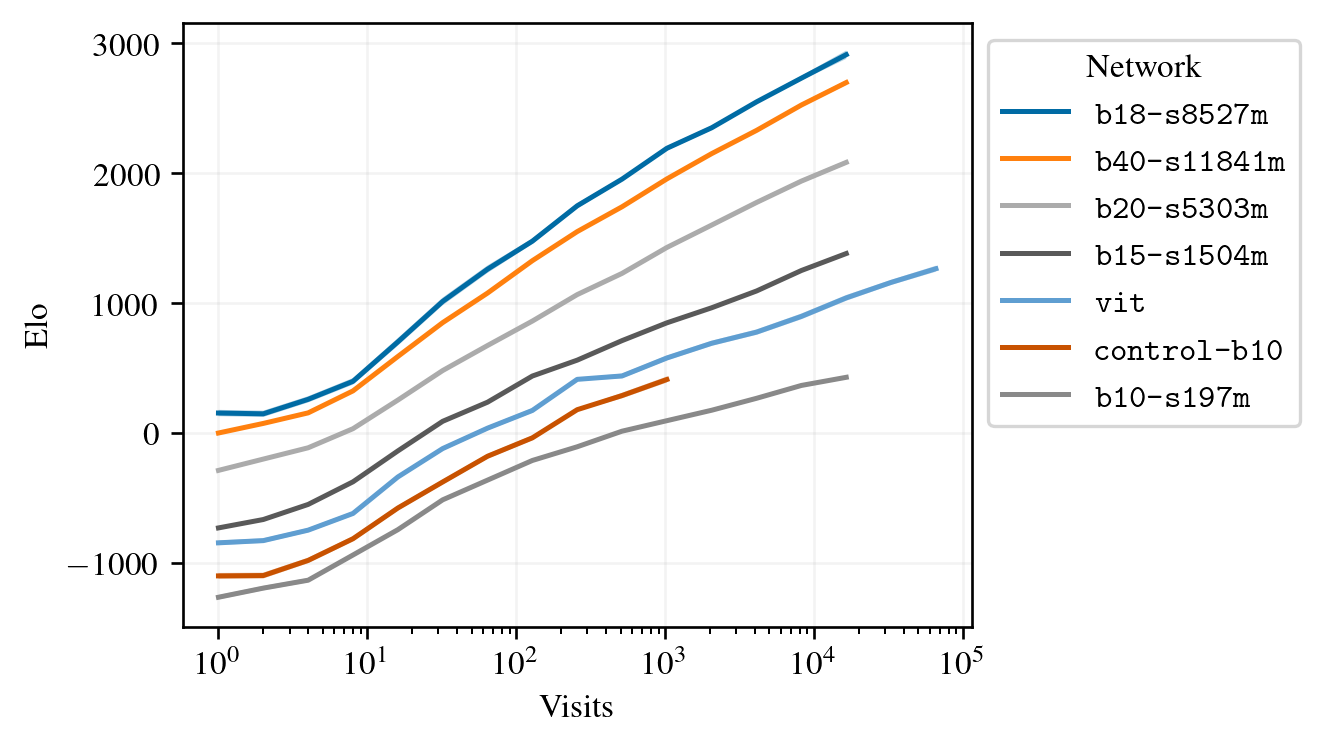

In [7]:
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(fig.get_figwidth() * 0.8) # Make main figure squarish.
plt.subplot(1, 1, 1)

match_path = pathlib.Path("/shared/ttseng/robustness-elo.txt")
lines = match_path.read_text().splitlines()
elo_lines_start_idx = lines.index("Elos (+/- one approx standard error):")
elo_lines_end_idx = lines.index(
    "Pairwise approx % likelihood of superiority of row over column:"
)
elo_lines = lines[elo_lines_start_idx + 1 : elo_lines_end_idx]

bot_entries: List[Dict[str, Union[float, int, str]]] = []
baseline_elo = 0
steps_regex = re.compile("-s(\d+)")
for elo_line in elo_lines:
    name = elo_line.split(":")[0].strip()
    steps_match = re.search(steps_regex, name)
    entry = {
        "name": name,
        "model": name.split("-v")[0],
        "architecture": name.split("-")[0] if steps_match is None else name.split("-s")[0],
        "steps": None if steps_match is None else int(steps_match.group(1)),
        "visits": int(name.split("-v")[1]),
        "elo": float(elo_line.split(":")[1].split("+/-")[0]),
        "stddev": float(elo_line.split("+/-")[1]),
    }
    bot_entries.append(entry)
    if name == "cp505-v1":
        baseline_elo = entry["elo"]
# Transpose all Elo scores so that baseline_elo is at 0.
for entry in bot_entries:
    entry["elo"] -= baseline_elo

# mapping of models to show on Elo plots to their label name
shown_models = {
    "b18-s8527m": r"\texttt{b18-s8527m}",
    "cp505": r"\texttt{b40-s11841m}",
    "cp127": r"\texttt{b20-s5303m}",
    "cp103": r"\texttt{b15-s1504m}",
    "vit-b16-s650025472": r"\texttt{vit}",
    "b10-s419465984": r"\texttt{control-b10}",
    "cp79": r"\texttt{b10-s197m}",
}

elo_df = pd.DataFrame(bot_entries)
for model, label in shown_models.items(): 
    data_by_visits = elo_df[elo_df["model"] == model].groupby("visits").mean(numeric_only=True)
    data_by_visits.elo.plot(label=label)
    plt.fill_between(data_by_visits.index, data_by_visits.elo - data_by_visits.stddev, data_by_visits.elo + data_by_visits.stddev, alpha=0.3)
plt.ylabel("Elo")
plt.xlabel("Visits")
plt.xscale("log")

plt.legend(
    title="Network",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    fancybox=True,
)

utils.filter_x_minor_ticks()
plt.gca().grid(True, alpha=0.15)

# Remove ticks from the right
plt.gca().yaxis.set_ticks_position("left")

plt.savefig("elo-by-visits.pgf", backend="pgf")

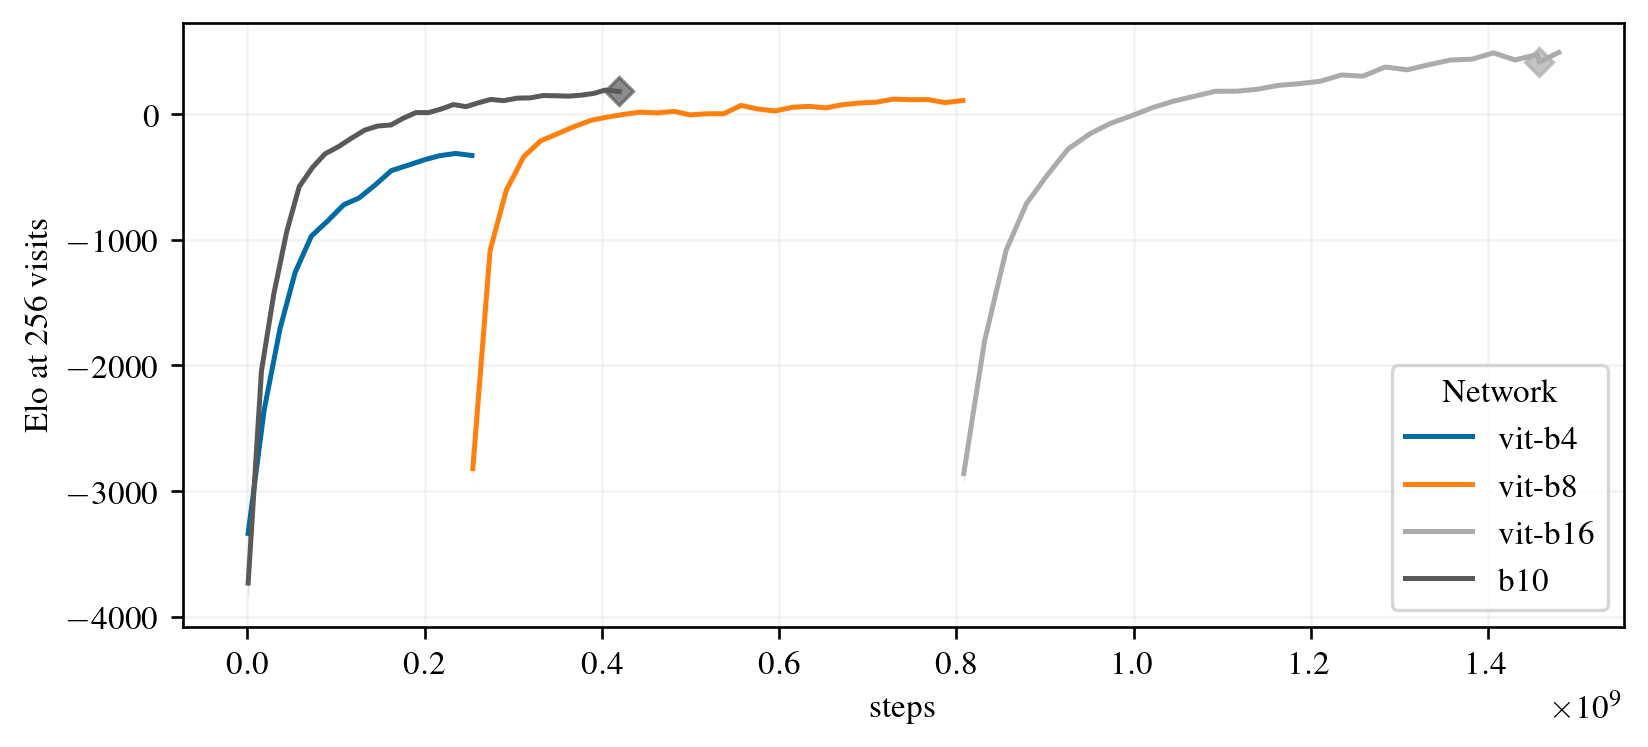

In [21]:
vit_b4_max_steps = elo_df[elo_df["architecture"] == "vit-b4"].steps.max()
vit_b8_max_steps = elo_df[elo_df["architecture"] == "vit-b8"].steps.max()

# (architecture, label, highlighted point step, step offset)
architectures_to_plot = [
    ("vit-b4", r"\texttt{vit-b16}", None, 0),
    ("vit-b8", r"\texttt{vit-b16}", None, vit_b4_max_steps),
    ("vit-b16", r"\texttt{vit-b16}", 650025472, vit_b4_max_steps + vit_b8_max_steps),
    ("b10", r"\texttt{control-b10}", 419465984, 0),
]

for i, (architecture, label, highlighted_point_step, step_offset) in enumerate(architectures_to_plot):
    data_by_steps = elo_df[(elo_df["architecture"] == architecture) & (elo_df["visits"] == 256) & (elo_df["steps"] != None)].groupby("steps").mean(numeric_only=True)
    data_by_steps.index += step_offset
    data_by_steps.elo.plot(label=architecture)
    plt.fill_between(data_by_steps.index, data_by_steps.elo - data_by_steps.stddev, data_by_steps.elo + data_by_steps.stddev, alpha=0.3)
    if highlighted_point_step is not None:
        highlighted_point_step += step_offset
        plt.plot(
            highlighted_point_step,
            data_by_steps.loc[highlighted_point_step].elo,
            "D",
            color=COLORS[i],
            alpha=0.7,
        )

plt.ylabel("Elo at 256 visits")
plt.gca().grid(True, alpha=0.15)
# Remove ticks from the right
plt.gca().yaxis.set_ticks_position("left")
plt.legend(
    title="Network",
    loc="lower right",
    fancybox=True,
)